In [ ]:
### requires scikit-learn>=1.3 for HDBSCAN

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis, norm
from sklearn.cluster import DBSCAN, HDBSCAN
%matplotlib inline

In [2]:
skews = np.load('/datax/scratch/benjb/skewnesses.npz')['arr_0']
kurts = np.load('/datax/scratch/benjb/kurtoses.npz')['arr_0']
sarles = np.load('/datax/scratch/benjb/sarles.npz')['arr_0']
corrs = np.load('/datax/scratch/benjb/new_new_corrs.npz')['arr_0']
tbws = np.load('/datax/scratch/benjb/new_new_tbws.npz')['arr_0']
tskews = np.load('/datax/scratch/benjb/temporal_skewnesses.npz')['arr_0']
tstds = np.load('/datax/scratch/benjb/tstds.npz')['arr_0']
fstds = np.load('/datax/scratch/benjb/fstds.npz')['arr_0']

In [3]:
lfiles = ['/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

filename = '/datax/scratch/benjb/m31_l_data/' + lfiles[0][44:-2] + 'dat'

df0 = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

freqs = df0['freq_start'].values
drifts = df0['Drift_Rate'].values
snrs = df0['SNR'].values

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_61738/672101961.py:10: SyntaxWarning: invalid escape sequence '\s'
  df0 = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',


In [4]:
data_arr = np.array([freqs/np.max(freqs), 
                     drifts/np.max(drifts), 
                     np.log10(snrs)/np.max(np.log10(snrs)), 
                     np.log10(np.abs(skews))/np.max(np.log10(np.abs(skews))), 
                     np.log10(kurts)/np.max(np.log10(kurts)), 
                     sarles, 
                     corrs, 
                     np.log10(tbws*1e6)/np.max(np.log10(tbws*1e6)),
                     (tskews-np.min(tskews))/np.max((tskews-np.min(tskews))),
                     np.log10(tstds)/np.max(np.log10(tstds)),
                     np.log10(fstds)/np.max(np.log10(fstds))
                     ])  ### PRE-PROCESSED FOR HDBSCAN

data_arr_unscaled = np.array([freqs, 
                     drifts, 
                     snrs, 
                     np.abs(skews), 
                     kurts, 
                     sarles, 
                     corrs, 
                     tbws*1e6,
                     tskews,
                     tstds,
                     fstds
                     ])

df = pd.DataFrame(np.transpose(data_arr),
                   columns=['frequency [MHz]', 
                            'drift rate [Hz/s]', 
                            'log10 SNR', 
                            'log10 magnitude of skewness', 
                            'log10 kurtosis', 
                            'Sarle\'s coefficient', 
                            'correlation coefficient [kurtosis vs. log(bandwidth)]', 
                            'log10 turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'log10 time-series standard deviation', 
                            'log10 power-spectrum standard deviation'])

dfu = pd.DataFrame(np.transpose(data_arr_unscaled),
                   columns=['frequency [MHz]', 
                            'drift rate [Hz/s]', 
                            'SNR', 
                            'magnitude of spectral skewness', 
                            'spectral kurtosis', 
                            'Sarle\'s coefficient', 
                            'correlation coefficient [kurtosis vs. log(bandwidth)]', 
                            'turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'time-series standard deviation', 
                            'power-spectrum standard deviation'])

In [5]:
dfu

,frequency [MHz],drift rate [Hz/s],SNR,magnitude of spectral skewness,spectral kurtosis,Sarle's coefficient,correlation coefficient [kurtosis vs. log(bandwidth)],turning-point bandwidth [Hz],temporal skewness,time-series standard deviation,power-spectrum standard deviation
0,1681.555894,0.040817,13.128177,8.573884,129.905700,0.573581,0.988025,63385.040351,0.691419,0.408708,0.057113
1,1681.542103,0.030613,12.317575,6.674641,87.374658,0.521328,0.982859,100000.000000,0.534756,0.442179,0.061947
2,1681.533109,0.040817,14.651185,6.566308,71.974816,0.612942,0.973850,100000.000000,0.109218,0.691577,0.073220
3,1681.528309,0.030613,26.196520,12.691490,202.851562,0.798978,0.973628,100000.000000,0.125301,0.738614,0.054852
4,1681.519315,0.040817,11.705699,6.025260,86.598273,0.430768,0.993980,79024.422765,0.665303,0.412869,0.060132
...,...,...,...,...,...,...,...,...,...,...,...
3063,1526.027322,-0.010204,92.912842,9.863639,127.855531,0.768769,0.682136,100000.000000,1.521115,0.346189,0.060766
3064,1526.019996,0.010204,60.508183,13.289182,245.777248,0.722615,0.982348,33037.928449,1.590035,0.342766,0.045880
3065,1525.987760,-0.020409,10.098998,12.303047,205.959836,0.739780,0.940611,68500.818775,0.962583,0.408880,0.049071
3066,1521.501754,-0.010204,50.440006,30.480743,941.578738,0.987783,0.950189,100000.000000,1.139316,0.365409,0.032335


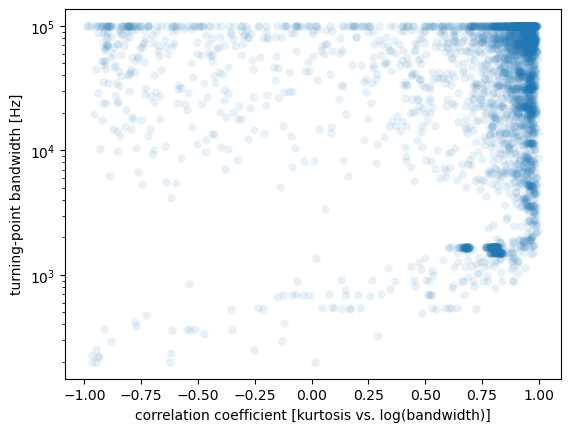

In [97]:
p1 = dfu.columns[6]
p2 = dfu.columns[7]
plt.scatter(dfu[p1].values, dfu[p2].values, alpha=0.1, linewidths=0)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel(p1)
plt.ylabel(p2)
plt.show()

Fitting ...
Making labels ...
Scattering ...
Refining ...


/tmp/ipykernel_2131849/764598378.py:47: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


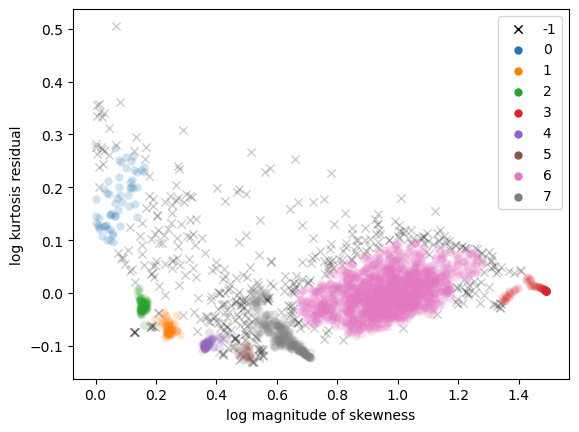

In [70]:
hdb = HDBSCAN(min_cluster_size=20, min_samples=20)

cut = 1

coef = np.polyfit(np.log10(np.abs(skews)[np.where(np.abs(skews) > cut)[0]]), np.log10(kurts[np.where(np.abs(skews) > cut)[0]]), 1)
poly1d_fn = np.poly1d(coef)

xunsorted = np.abs(skews)[np.where(np.abs(skews) > cut)[0]]
xmodunsorted = np.log10(xunsorted)
ymodunsorted = poly1d_fn(xmodunsorted)
yunsorted = 10**ymodunsorted

x = np.log10(np.abs(skews)[np.where(np.abs(skews) > cut)[0]])
y = np.log10(kurts[np.where(np.abs(skews) > cut)[0]]) - ymodunsorted

print('Fitting ...')

X = np.transpose(np.array([x, y]))
hdb.fit(X)

#labels = hdb.labels_
print('Making labels ...')
labels_list = hdb.labels_
labels = np.unique(labels_list)
#print(labels)

print('Scattering ...')
for l in labels:
    idxs = np.where(labels_list == l)
    #print(idxs)
    if l == -1.:
        plt.scatter(x[idxs], y[idxs], color='k', marker='x', alpha=0.2, linewidths=1, label=l)
    else:
        plt.scatter(x[idxs], y[idxs], alpha=0.2, linewidths=0, label=l)

print('Refining ...')

#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('skewness')
#plt.ylabel('kurtosis')

plt.xlabel('log magnitude of skewness')
plt.ylabel('log kurtosis residual')

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.show()

Fitting ...
Making labels ...
Scattering ...
Refining ...


/tmp/ipykernel_2131849/3448131167.py:52: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


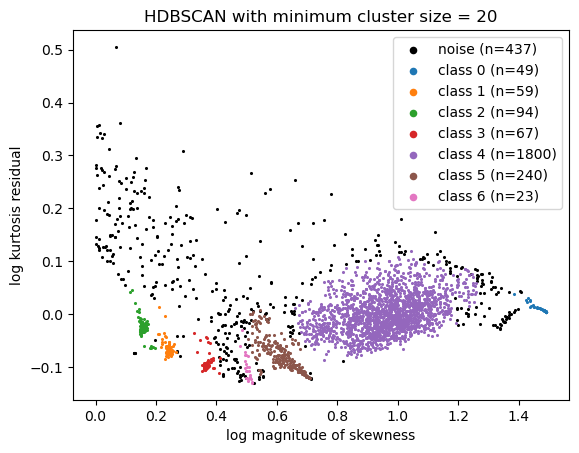

In [102]:
nmincluster = 20
hdb = HDBSCAN(min_cluster_size=nmincluster, min_samples=nmincluster)

cut = 1

coef = np.polyfit(np.log10(np.abs(skews)[np.where(np.abs(skews) > cut)[0]]), np.log10(kurts[np.where(np.abs(skews) > cut)[0]]), 1)
poly1d_fn = np.poly1d(coef)

xunsorted = np.abs(skews)[np.where(np.abs(skews) > cut)[0]]
xmodunsorted = np.log10(xunsorted)
ymodunsorted = poly1d_fn(xmodunsorted)
yunsorted = 10**ymodunsorted

x = np.log10(np.abs(skews)[np.where(np.abs(skews) > cut)[0]])
y = np.log10(kurts[np.where(np.abs(skews) > cut)[0]]) - ymodunsorted

#x = np.abs(skews)[np.where(np.abs(skews) > cut)[0]]
#y = kurts[np.where(np.abs(skews) > cut)[0]]

print('Fitting ...')

X = np.transpose(np.array([x, y+ymodunsorted]))
hdb.fit(X)

#labels = hdb.labels_
print('Making labels ...')
labels_list = hdb.labels_
labels = np.unique(labels_list)
#print(labels)

print('Scattering ...')
for l in labels:
    idxs = np.where(labels_list == l)[0]
    #print(idxs)
    if l == -1.:
        plt.scatter(x[idxs], y[idxs], color='k', s=5, linewidths=0, label=f'noise (n={len(idxs)})')
    else:
        plt.scatter(x[idxs], y[idxs], s=5, linewidths=0, label=f'class {l} (n={len(idxs)})')

print('Refining ...')

#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('skewness')
#plt.ylabel('kurtosis')

plt.xlabel('log magnitude of skewness')
plt.ylabel('log kurtosis residual')
plt.title(f'HDBSCAN with minimum cluster size = {nmincluster}')

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([30])

plt.show()

In [98]:
for ii, name in enumerate(dfu.columns):
    print(f'{ii}: {name}')

0: frequency [MHz]
1: drift rate [Hz/s]
2: SNR
3: magnitude of spectral skewness
4: spectral kurtosis
5: Sarle's coefficient
6: correlation coefficient [kurtosis vs. log(bandwidth)]
7: turning-point bandwidth [Hz]
8: temporal skewness
9: time-series standard deviation
10: power-spectrum standard deviation


(3068, 11)
Making labels ...
21
Scattering ...
Refining ...


/tmp/ipykernel_61738/96471331.py:58: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


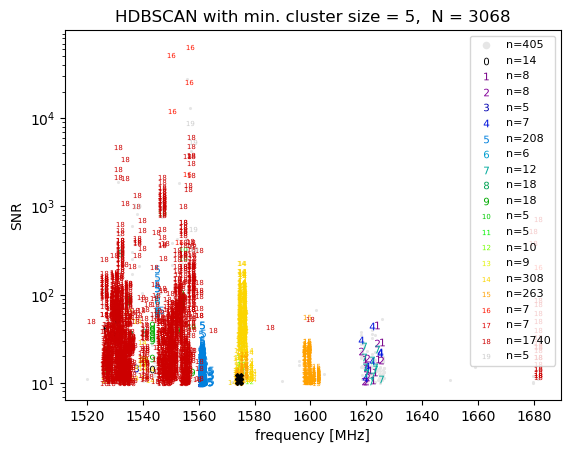

In [68]:
import matplotlib.cm as cm

nmincluster = 5
nminsamples = 3
eps = 0.24

col_idx_x = 0
col_idx_y = 2

hdb = HDBSCAN(min_cluster_size=nmincluster, min_samples=nminsamples, cluster_selection_epsilon=eps)

X = np.transpose(data_arr)
hdb.fit(X)

print(np.shape(X))

print('Making labels ...')
labels_list = hdb.labels_
labels = np.unique(labels_list)
print(len(labels))

x_param = dfu.columns[col_idx_x]
y_param = dfu.columns[col_idx_y]

x = dfu[x_param].values
y = dfu[y_param].values

colors = cm.nipy_spectral(np.linspace(0, 1, len(labels)-1))

print('Scattering ...')
for l in labels:
    idxs = np.where(labels_list == l)[0]
    if l == -1.:
        plt.scatter(x[idxs], y[idxs], color='0.9', s=5, linewidths=0, label=f'n={len(idxs)}')
    else:
        plt.scatter(x[idxs], y[idxs], marker=f'${l}$', color=colors[l], s=30, linewidths=0, label=f'n={len(idxs)}')

other_idxs = np.array([683, 691])

plt.scatter(x[other_idxs], y[other_idxs], color='k', s=30, marker='X')

print('Refining ...')

if 'log10' in df.columns[col_idx_x]:
    plt.xscale('log')
else:
    plt.xscale('linear')
if 'log10' in df.columns[col_idx_y]:
    plt.yscale('log')
else:
    plt.yscale('linear')

plt.xlabel(x_param)
plt.ylabel(y_param)
plt.title(f'HDBSCAN with min. cluster size = {nmincluster},  N = {len(x)}')

leg = plt.legend(fontsize=8)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([30])
#plt.xscale('log')
#plt.yscale('log')

#plt.savefig(f'HDBSCAN_clustering_{col_idx_x}_{col_idx_y}.pdf')

plt.show()

In [48]:
np.savez(f'/datax/scratch/benjb/hdbscan_labels_{nmincluster}_{nminsamples}_{eps}.npz', labels_list)

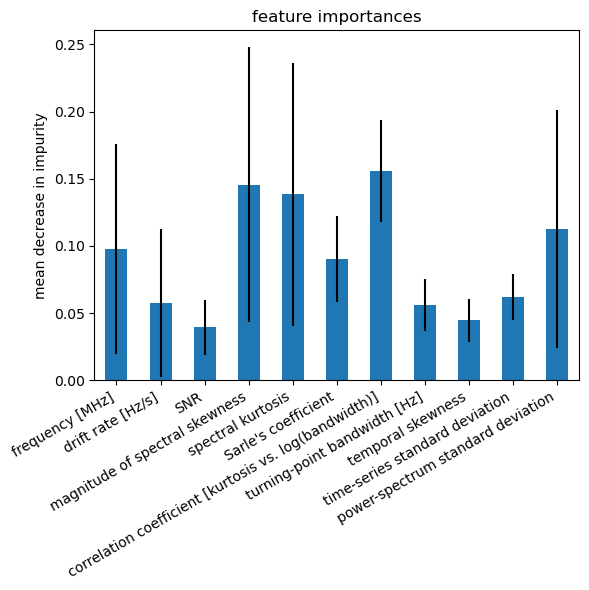

In [73]:
from sklearn.model_selection import train_test_split

y = labels_list

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

from sklearn.ensemble import RandomForestClassifier

#feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = dfu.columns
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(6,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("feature importances")
ax.set_ylabel("mean decrease in impurity")
plt.xticks(rotation=30, ha="right")
fig.tight_layout()
plt.savefig('HDBSCAN_feature_importances.pdf')